In [104]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2370/1887457916.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")


,level,jp,rajp,htv,ptv,rtv,ad,aw1,aw2,aw3,...,VeDBA,bottom,stime,etime,label,divenum,abs_roll,diveDuration,delt_d,elev
ID,,,,,,,,,,,,,,,,,,,,,
D26,9567,9564,9545,9544,9544,9544,9564,9544,9544,9544,...,9544,9564,9564,9564,9567,9567,9544,575,9561,9564


<AxesSubplot:>

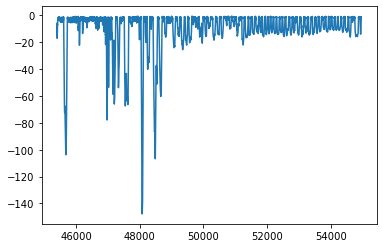

In [105]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated('divenum'),feature] = np.nan

#df["w_low"] = np.log(df["w_low"])
#df["w_high"] = np.log(df["w_high"])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"]

display(df.groupby("ID").count())
df["elev"].plot()

# Define Parameters

In [106]:
# parse command-line args
max_time = 10*60
id = 8

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

### features of data ###
features = {'diveDuration'     : {'f'           : 'gamma',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': False,
                                  'share_fine'  : True},
            'aw1'              : {'f'           : 'normal_AR',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'aw2'              : {'f'           : 'normal_AR',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'aw3'              : {'f'           : 'normal_AR',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'w_low'            : {'f'           : 'gamma',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False}}

# define jump_inds
jump_inds = []
for i,datum in enumerate(data):
    if not np.isnan(datum['diveDuration']):
        jump_inds.append(i)

method: SVRG
partial E_step: 0.5
random seed: 0
max time : 0.167 hours


# Define shared parameters

In [107]:
share_params = []

# share coarse scale dive duration
for feature in ['diveDuration']:
    for param in ['log_mu','log_sig']:
        for k0 in range(K[0]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0],
                                 "K_fine"  :[k1 for k1 in range(K[1])]})

# share fine scale acceleration
for feature in ['aw1','aw2','aw3']:
    for param in ['log_mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
# share autocorrelation for acceleration
for k1 in range(K[1]):
    share_params.append({"features":['aw1','aw2','aw3'],
                         "params"  :['logit_phi'],
                         "K_coarse":[k0 for k0 in range(K[0])],
                         "K_fine"  :[k1]})
            
# share params for "w_low"
for feature in ['w_low']:
    for param in ["mu","log_sig"]:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})

In [108]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[9566]


# Plot Data

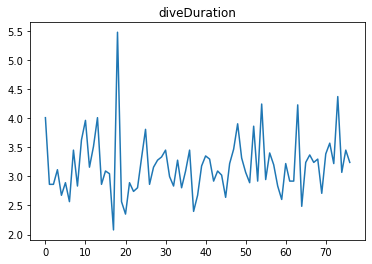

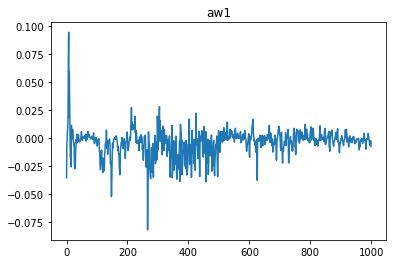

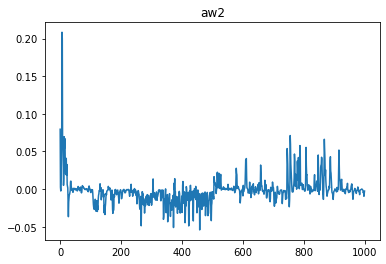

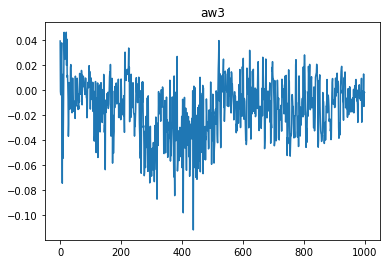

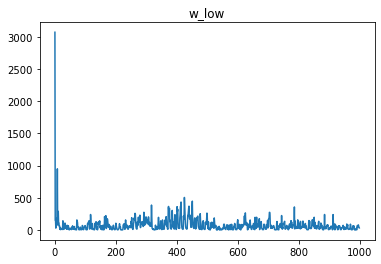

<AxesSubplot:>

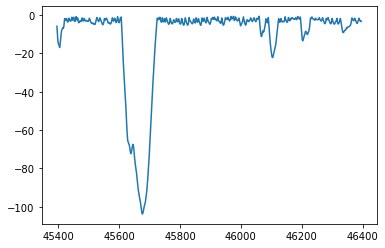

In [109]:
for feature in features:
    plt.plot([datum[feature] for datum in data[:1000] if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].iloc[0:1000].plot()

# Initialize HMM

In [115]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

T = len(data)
K = [2,3]

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,K)

optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds

optim.share_params = share_params

#for feature in features:
#    optim.param_bounds[feature] = {}
#    optim.param_bounds[feature]["mu"] = [-100,100]
#    optim.param_bounds[feature]["log_sig"] = [-5,5]

if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] * np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) * np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

'''
optim.theta = [{'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'w_low': {'log_mu': array([2.0, 2.0, 2.0]),
                          'log_sig': array([1.0, 1.0, 1.0])}},
               {'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'w_low': {'log_mu': array([2.0, 2.0, 2.0]),
                          'log_sig': array([1.0, 1.0, 1.0])}}]

optim.eta = [array([[ 0.        , -3.0],
                    [-3.0,  0.        ]]),
             [array([[ 0.0  , -1.0  , -100.0],
                     [-100.0, 0.0   , -1.0  ],
                     [-1.0  , -100.0, 0.0   ]]),
              array([[ 0.0  , -2.0  , -100.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-2.0  , -100.0, 0.0   ]])]]

optim.eta0 = [array([0.0, 0.0]),
             [array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0])]]


optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()
'''

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
diveDuration
{'log_mu': array([1.13856306, 1.13856306, 1.13856306]), 'log_sig': array([-0.14929058, -0.14929058, -0.14929058])}

aw1
{'mu': array([-0.01951965,  0.00123413, -0.00378912]), 'log_sig': array([-4.52017001, -4.52017001, -4.52017001]), 'logit_rho': array([-0.95583459, -3.26322495, -1.24681177])}

aw2
{'mu': array([-0.00593069,  0.00694631,  0.00052675]), 'log_sig': array([-4.35868036, -4.35868036, -4.35868036]), 'logit_rho': array([-1.68038383,  0.91826072,  0.08073328])}

aw3
{'mu': array([-0.00640626,  0.01383801, -0.0019346 ]), 'log_sig': array([-4.03876576, -4.03876576, -4.03876576]), 'logit_rho': array([-1.3505765 , -0.2238841 ,  0.05589884])}

w_low
{'log_mu': array([3.74101674, 3.31568351, 3.19730725]), 'log_sig': array([4.26217761, 4.26217761, 4.26217761])}


diveDuration
{'log_mu': array([1.17354158, 1.17354158, 1.17354158]), 'log_sig': array([-0.14929058, -0.14929058, -0.14929058])}

aw1
{'mu': array([-0.01951965,  0.00123413, -0.00378912]), 'log_sig

# Train the HMM

In [7]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=10,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

initial theta:
[{'delt_d': {'mu': array([-1.33649632, -0.76327092, -0.04862618]), 'log_sig': array([-0.12677973, -0.12677973, -0.12677973]), 'logit_rho': array([-1.10731045,  0.36546718, -1.09769572])}, 'w_low': {'log_mu': array([3.39377783, 3.77418306, 3.45056065]), 'log_sig': array([4.26217761, 4.26217761, 4.26217761])}}, {'delt_d': {'mu': array([-1.33649632, -0.76327092, -0.04862618]), 'log_sig': array([-0.12677973, -0.12677973, -0.12677973]), 'logit_rho': array([-1.10731045,  0.36546718, -1.09769572])}, 'w_low': {'log_mu': array([3.39377783, 3.77418306, 3.45056065]), 'log_sig': array([4.26217761, 4.26217761, 4.26217761])}}]

initial eta0:
[array([ 0.        , -0.21195226]), [array([ 0.        , -0.08033726,  0.40539778]), array([0.        , 0.11860659, 1.25441407])]]

initial eta:
[array([[ 0.        ,  2.7644489 ],
       [-2.81204747,  0.        ]]), [array([[ 0.        , -1.11410253, -1.84423086],
       [-0.29435919,  0.        , -1.82719653],
       [-1.4157447 , -1.52451219, 

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/stoch_optimizor.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  elif ((ll_new - ll_old)/np.abs(ll_old)) < tol:


M-step failed to converge: maximum number of iterations reached
...done

L_theta:  [66.68598997 34.56550749 33.88608558 66.68598997 34.56550749 33.88608558]
alpha_theta:  [0.00499855 0.00964352 0.00983688 0.00499855 0.00964352 0.00983688]
L_eta:  33.330918105539034
alpha_eta:  0.010000724620842023


starting epoch 3.0

0.004 hours elapsed

starting E-step...
...done

current parameters:
[{'delt_d': {'mu': array([-0.22347422, -1.56500254,  0.17189521]), 'log_sig': array([ 0.39135096, -1.75584688, -1.0521571 ]), 'logit_rho': array([-0.14474257,  3.16115084, -0.73252707])}, 'w_low': {'log_mu': array([4.42140087, 2.6287911 , 4.11497084]), 'log_sig': array([4.72211169, 2.7875634 , 4.1942155 ])}}, {'delt_d': {'mu': array([-0.22347422, -1.56500254,  0.17189521]), 'log_sig': array([ 0.39135096, -1.75584688, -1.0521571 ]), 'logit_rho': array([-0.14474257,  3.16115084, -0.73252707])}, 'w_low': {'log_mu': array([4.42140087, 2.6287911 , 4.11497084]), 'log_sig': array([4.72211169, 2.7875634 , 4.194

KeyboardInterrupt: 

In [ ]:
expit(10)

In [ ]:
optim.param_bounds

In [ ]:
optim.theta

In [ ]:
optim.eta

In [ ]:
optim.eta0

# Save the HMM

In [ ]:
file = "case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/large/Mar-02-2023"):
    os.mkdir("../params/large/Mar-02-2023")

with open("../params/large/Mar-02-2023/" + file, 'wb') as f:
    pickle.dump(optim, f)